<a href="https://colab.research.google.com/github/AntonWaldron/AntonShouldBeSleeping/blob/main/ImageRecognitionProject-Is-It-Ten-Hag%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is a take on 'Is it a Bird' from fastai lesson 1, but with 3 categories instead of 2.

### Lesson 2 incorporated as well.

In [2]:
#Ensuring that the latest volume of fastai+ is used.

import os
!pip install -Uqq fastai
!pip install -Uqq duckduckgo_search
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

from duckduckgo_search import DDGS
from fastcore.all import *
from fastai.vision.widgets import *

def search_images(keywords, max_images = 30):
    print(f"Searching for {keywords}")
    return L(DDGS().images(keywords,max_results=max_images)).itemgot('image')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 87.1 MB/s eta 0:00:00


# Step 1 - Download images of Ten Hag and not Ten Hag

1. Search for images with the keyword 'Erik Ten Hag'
    - Set a limit of one image.
    - Store the url of the first image.

2. Download the image
    - Set the destination filename eg. ETH.jpg
    - Download the image from the url and store it in the destination ETH.jpg

3. Display/Open the image
4. Resize the image to be 256x256 pixels.

Searching for Erik Ten Hag


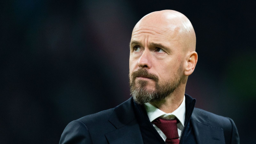

In [3]:
urls = search_images('Erik Ten Hag', max_images=1)
urls[0]

from fastdownload import download_url
dest = 'ETH.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now we do the same thing but for a different Bald Fraud as well as Jurgen Klopp.

Searching for Pep Guardiola
Searching for Jurgen Klopp


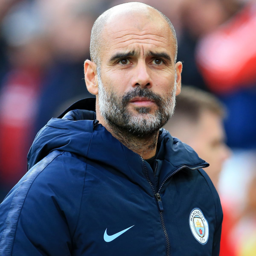

In [4]:
download_url(search_images('Pep Guardiola', max_images=1)[0], 'PepGuardiola.jpg', show_progress=False)
download_url(search_images('Jurgen Klopp', max_images=1)[0],'JurgenKlopp.jpg', show_progress=False)
Image.open('PepGuardiola.jpg').to_thumb(256,256)

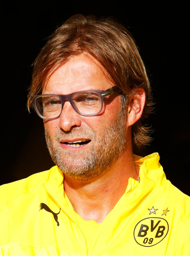

In [5]:
Image.open('JurgenKlopp.jpg').to_thumb(256,256)

The searches seem good. They give us what we are looking for. Now we need a few different examples and to save them to folders.

1. Initialise variables:
        
    - Define a list called 'searches' containing the terms 'Erik Ten Hag', 'Pep Guardiola' and 'Soccer managers'.
    - Define a directory path where images will be saved, TenHag_or_not.
2. Iterate through the search terms:
    
    * Create a directory named after the search term within the base path. If it already exists do not create it again.
    
    ***Download Images for Various Queries**
    
    The loop will save images for 'searches' photo, 'searches' young, and 'searches' managing.
    Resize the downloaded images and save them back in the same directory.

In [10]:
searches = 'Erik Ten Hag','Pep Guardiola', 'Jurgen Klopp'
path = Path('TenHag_or_not')
from time import sleep

for o in searches:          #This is a for loop, iterates through everything in "searches"
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))          # Searches Erik Ten Hag photo, Pep ... photo, Klopp ... photo
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} young'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} managing'))
    resize_images(path/o, max_size=400, dest=path/o)

#To reinforce the association between the managers and the teams they're most known for managing
download_images(path/'Erik Ten Hag', urls = search_images('Erik Ten Hag Manchester United'))
resize_images(path/'Erik Ten Hag', max_size=400, dest=path/'Erik Ten Hag')

download_images(path/'Pep Guardiola', urls = search_images('Pep Guardiola Manchester City'))
resize_images(path/'Pep Guardiola', max_size=400, dest=path/'Pep Guardiola')

download_images(path/'Jurgen Klopp', urls = search_images('Jurgen Klopp Liverpool FC'))
resize_images(path/'Jurgen Klopp', max_size=400, dest=path/'Jurgen Klopp')

Searching for Erik Ten Hag photo
Searching for Erik Ten Hag young
Searching for Erik Ten Hag managing
Searching for Pep Guardiola photo
Searching for Pep Guardiola young
Searching for Pep Guardiola managing
Searching for Jurgen Klopp photo
Searching for Jurgen Klopp young
Searching for Jurgen Klopp managing
Searching for Erik Ten Hag Manchester United
Searching for Pep Guardiola Manchester City
Searching for Jurgen Klopp Liverpool FC


# Step 2: Training the model
## Removing corrupted photos

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

1. Retrieve all the training images.
    Get a list of the images in the specified directory 'path'
    
2. Verify the image files
    Verify that they are not corrupt.
    Store any images that are corrupt in a list called 'failed'.
    
3. Remove Corrupted Images
   For each file in the 'failed' list:
    * Delete the file from the directory.
        
4. Count the failed images.


In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

36

## Creating the DataBlock for Image Classification
1. Define a DataBlock for image classification:
    
     - Set up the structure to handle images as input data and categories.
    
2. Specify the data structure:

    - Use 'ImageBlock' for images.
    - Use 'CategoryBlock' for categories.
    
3. Retrieve the image files:
    
    - Use 'get_image_files' to collect all image files from the specified directory.
    
4. Split the dataset: Create a validation and testing set.

5. Extract lables from image paths:

    - Use 'parent_label' to get lables based on the parent directory.
    
6. Resize all images.

7. Create DataLoaders for training:

    - Generate DataLoaders to manage and load data in batches during  the training process.
    
    - Set the batch size to 32 images per batch.
    
8. Display a sample batch.

     - Show a batch of 6 to confirm that the labels are working correctly.

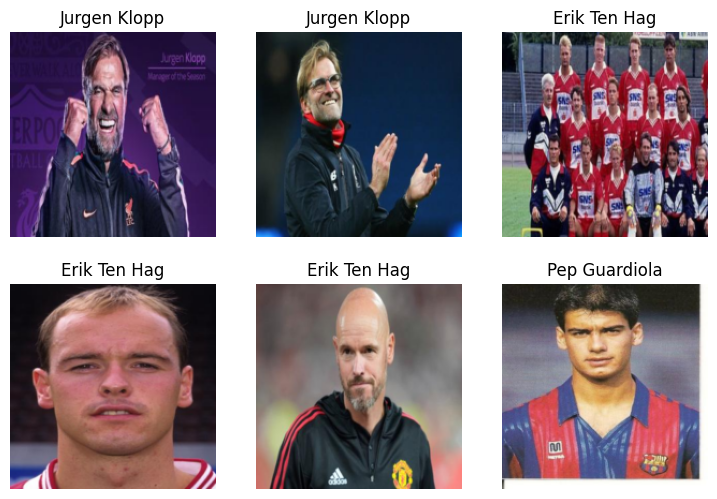

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #Validation set
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)
#print(dls.vocab) #This informs us of the order the classnames were used in the model (based on 'searches' we defined previously.)


## Actually Training the Model
Time to train the model, to change things around I used resnet34 instead of resnet18 for this model.
Previously I had tried to use alexnet but the learn process took a very long time.

1. Initialise a Vision Learner:
    * Create a 'vision_learner' to perform image classification.
    * Use the 'DataLoaders' ('dls') containing the training and validation data.
    * Choose a pretrained 'resnet50' model as the neural network architecture.
    * Specify the 'error_rate' as the evaluation metric to monitor the training.

2. Fine-Tune the Model:
    * Fine-tune the pre-trained 'resnet50' model on the dataset.
    * Perform the fine-tuning for 3 epochs (full passes through the training data)

In [13]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(5)

The error rate is a lot lower after adding in the searches with their clubs.

## Testing the Model on recognizing Ten Hag

This is a: Erik Ten Hag.
Probability that this is Erik Ten Hag: 0.9979


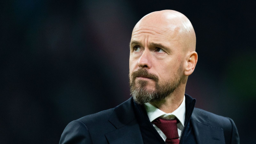

In [14]:
is_HAG,_,probs = learn.predict(PILImage.create('ETH.jpg'))
print(f"This is a: {is_HAG}.")
print(f"Probability that this is Erik Ten Hag: {probs[0]:.4f}")
Image.open('ETH.jpg').to_thumb(256,256)

Delicious result

# Changing the Model from "Is it Ten Hag?" to "Is it Pep?"

1. Search for a sample image of Pep Guardiola.
2. Override Ten Hag and save this to urls index 0.
3. Save it to Pep.jpg
4. Download the image.
5. Use _is_guardiola_ to check whether or not the picture is Pep.
    * This works because is_guardiola is defined with the PepGuardiola image
    
6. Print the result and probability.

Searching for Pep Guardiola


This is a: Pep Guardiola.
Probability that this is Pep Guardiola: 0.9999


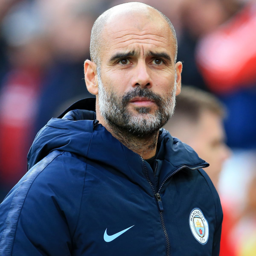

In [15]:
urls = search_images('Pep Guardiola', max_images=1)
urls[0]
dest = 'Pep.jpg'
download_url(urls[0], dest, show_progress=False)


is_guardiola, _, probs = learn.predict(PILImage.create('PepGuardiola.jpg'))

print(f"This is a: {is_guardiola}.")
print(f"Probability that this is Pep Guardiola: {probs[2]:.4f}") #Here we use probs[1] because Pep is the 2nd class in the model's vocabulary.
Image.open('Pep.jpg').to_thumb(256,256)

Including the club related searches has vastly improved the model - previously this would have been around 0.6 percent probability.

## More training from lesson 2

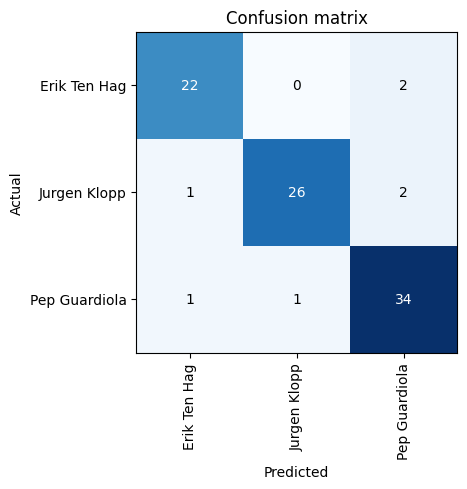

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The model is much better now, adding the aditional epochs really helped with the accuracy.

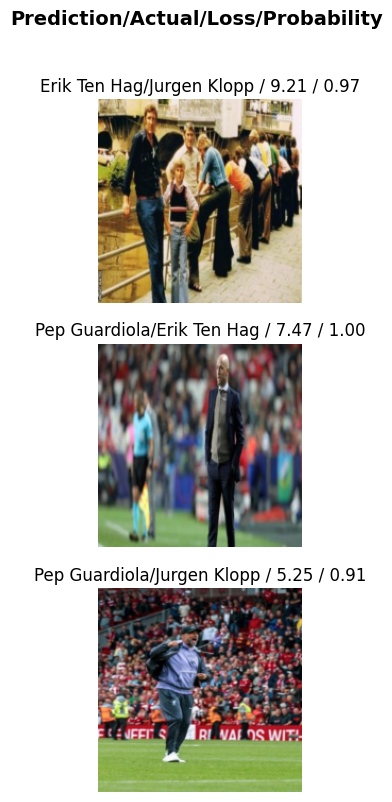

In [17]:
interp.plot_top_losses(3, nrows=3)

In [18]:
# Initialize the cleaner with all data
cleaner = ImageClassifierCleaner(learn)
cleaner

It works in Colab! I have filtered through the options in the Training dataset and deleted some that were incorrect. This should improve model accuracy.

In [19]:
#To delete the photos we do
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

#To move images for which we've selected a different category we do
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Now I'm unsure what happens next but I'll just follow along the fastai lecture.

# Turning my model into an online application

In [1]:
learn.export()

NameError: name 'learn' is not defined